# Parameter initialization 

Some personal notes on parameter initialization to develop my intuition. I will be adding more content to this as I go along.

<img src='images/computers_vs_humans.png' width='400' height='400'/>

Source: https://xkcd.com/1875/

In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# set style for seaborn charts 
sns.set_style("whitegrid")
%matplotlib inline

# switch off deprecation warnings
import warnings
warnings.filterwarnings("ignore")

### Write forward pass illustration function
- Similar to the notebook on activation functions in this repository, I will be using a simple forward pass of a fully connected network to show effects of different initializations of the parameter W (and its interaction with different activation functions). The code produces random Gaussian inputs and forward propagates it through 10 layers with a chosen activation function. Activations in each layer are cached to visualize their statistics. 

Source: The snippet is based on lecture 5 of Stanford's "CS231n" course of 2016 on neural networks (with some adjustments and additions) 

In [3]:
# define activation functions
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

# define function
def tanh(Z):
    return (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))

# define ReLU 
def relu(Z):
    return np.maximum(0, Z)

# define leaky ReLU 
def leaky_relu(Z, epsilon=0.1):
    return np.where(Z > 0, Z, epsilon*Z)

# define Softplus 
def softplus(z):
    return np.log(1+np.exp(z))

# define ELU
def elu(Z, alpha=1):
    return np.where(Z > 0, Z, alpha*(np.exp(Z)-1))

# define swish
def swish(z):
    return z/(1+np.exp(-z))

In [4]:
# create simple forward pass function 
def forward_pass(activation_function, init_parameter=0.01):
    """
    Arguments:
        activation_function -- 'sigmoid', 'tanh', 'relu', 'leaky_relu', 'softplus', 'elu', 'swish'
        init_parameter -- parameter to be multiplied with the zero-centered Gaussian random normal distribution that initializes
                        the weights W 
    Retuns: 
        cache of activations for each layer 
    """
    # create Gaussian random inputs with 1000 samples of 500 features 
    X = np.random.randn(500, 1000)

    # define shape for 10 layers as having 500 neurons each 
    hidden_layer_size = [500] * 10

    # define dict of possible activation functions to call the activation functions defined in this notebook 
    activation_functions = {'sigmoid': sigmoid, 'tanh': tanh, 'relu': relu, 'leaky_relu': leaky_relu, 'softplus': softplus,
                           'elu': elu, 'swish': swish}

    # create dictionary to cache activation values for each layer in the forward pass 
    activation_cache = {}

    # loop through all layers 
    for i in range(len(hidden_layer_size)):
        # set input for next layer as that of the pevious layer 
        if i == 0: 
            previous_layer_activation = X 
        else: 
            previous_layer_activation = activation_cache[i-1]

        # find shape of parameter array at current layer 
        in_shape = previous_layer_activation.shape[0]
        out_shape = hidden_layer_size[i]

        # initialize weights 
        W = np.random.randn(out_shape, in_shape) * init_parameter
 
        # calculate linear forward output of layer 
        Z = np.dot(W, previous_layer_activation)
         
        # calculate non-linear output (activation)
        A = activation_functions[activation_function](Z)
  
        # cache activations
        activation_cache[i] = A 
        
    return activation_cache 

# plot mean and standard deviation of layers from simple forward pass 
def plot_stats(cache): 
    df = pd.DataFrame()
    for i in range(len(cache)): 
        df_temp = pd.DataFrame({'mean': np.mean(cache[i]).ravel(), 'std': np.std(cache[i]).ravel(), 'layer': i})
        df = pd.concat([df, df_temp]) 

    fig, ax =plt.subplots(1,2, figsize=(15,5))
    sns.lineplot(x='layer', y='mean', data=df, ax=ax[0], label='activations mean')
    sns.lineplot(x='layer', y='std', data=df, ax=ax[1], label='activations standard deviation', color="r")
    fig.show()

# plot histogram of distriution of activations per layer from simple forward pass 
def plot_hist(cache): 
    df = pd.DataFrame()
    for i in range(len(cache)):
        df_temp = pd.DataFrame({'activations': cache[i].ravel(), 'layer': i})
        df = pd.concat([df, df_temp])
    # bring all plots onto one chart with 5 charts per row 
    chart = sns.FacetGrid(df, col="layer", col_wrap=5)
    chart.map(sns.distplot, 'activations', bins=np.arange(-1.1,1.1,0.05), kde=False)

## Xavier initialization 

### Tackling the issue of vanishing gradients 
The motivation is to be able to use **the tanh activation funtion and prevent gradients of the parameter W from vanishing** by either initializing those parameters too closely around zero (which causes activations to collapse to zero) or too far away from zero (which causes activations to cluster at +1 and -1. See notebook on activation function for more thorough treatment of the vanishing gradient issue: https://github.com/PhilSorgenfrei/ML_notes/blob/master/Activation_functions.ipynb 

Below are two sets of histograms which depict the cases when the parameter W is initialized too close to zero and too far away from zero respectively: 

1. activations collapsing to zero 
2. activations clustering at +1 and -1

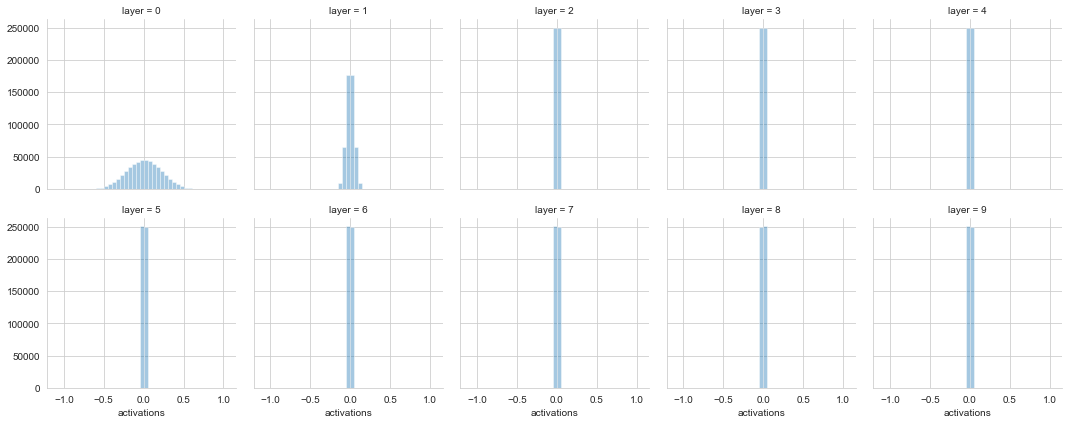

In [13]:
cache = forward_pass('tanh', init_parameter=0.01)
plot_hist(cache)

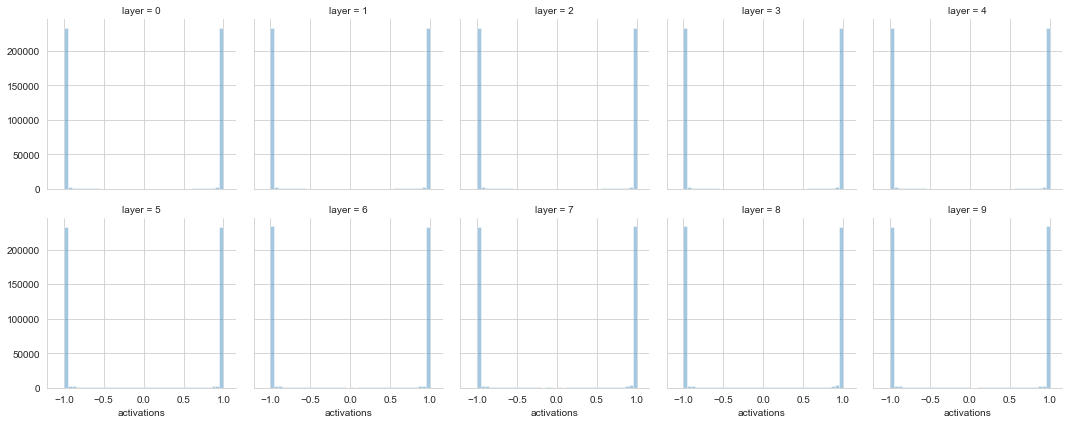

In [12]:
cache = forward_pass('tanh', init_parameter=1)
plot_hist(cache)

Xavier initialization initializes W by setting it to be a Gaussian random normal distribution **divided by the square root of the number of inputs to a layer.** Thus, the larger the input layer, the smaller on average the values of W of that layer (which intuitively makes sense, because the activation function is applied to the sum of the product input_values * W) 

Initializing our test forward pass this way, yields the following more balanced histograms. However, with ever deeper layers, we still observe a trend towards ever tighter clustering around zero (albeit less pronounced)

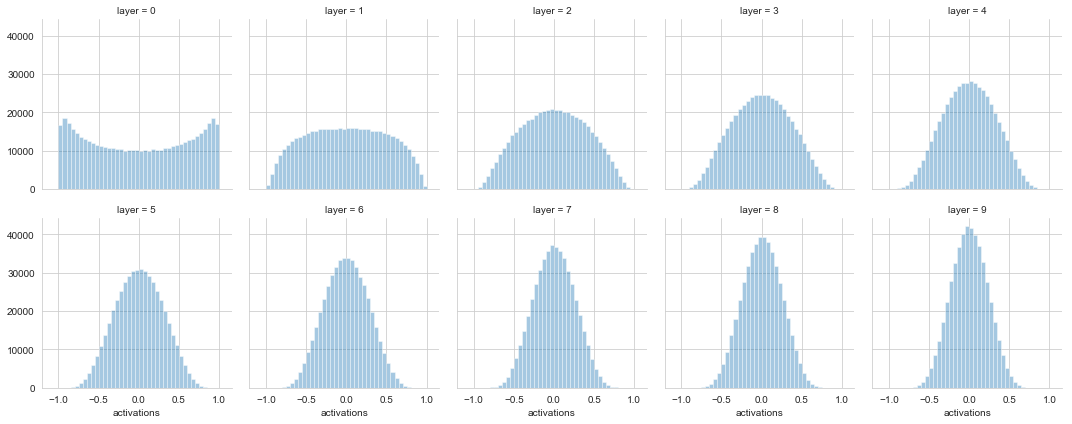

In [11]:
cache = forward_pass('tanh', init_parameter=1/np.sqrt(500))
plot_hist(cache)

## He initialization 

He initialization aims to prevent activations in a **ReLU network** from being trapped at zero over time, as any neuron ever receiving a negative input will output zero and stop learning (at least when not using stochastic gradient descent)

The below chart of activations in our forward pass shows how activations converge to zero when not choosing the parameter initialization carefully.

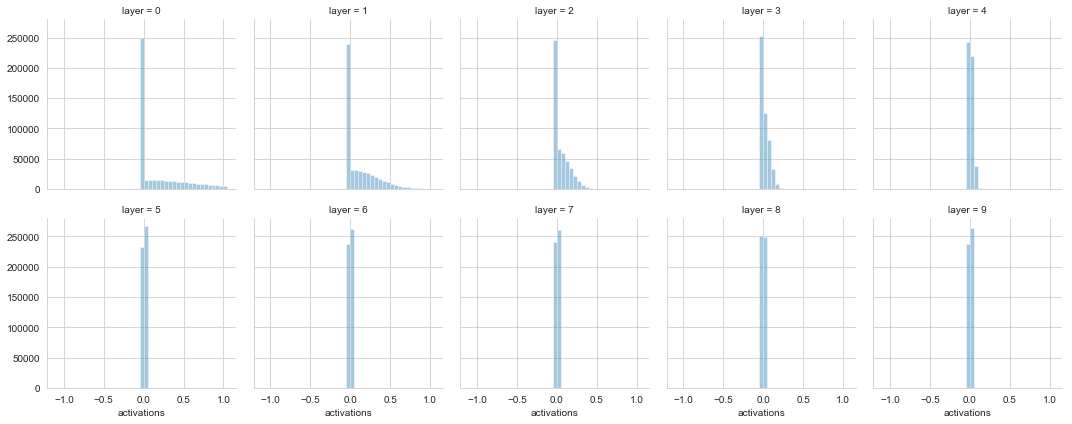

In [17]:
cache = forward_pass('relu', init_parameter=0.03)
plot_hist(cache)

He initialization initializes W by setting it to be a Gaussian random normal distribution **divided by half the square root of the number of inputs to a layer.** 

Initializing our test forward pass this way, yields the following more balanced histograms. 

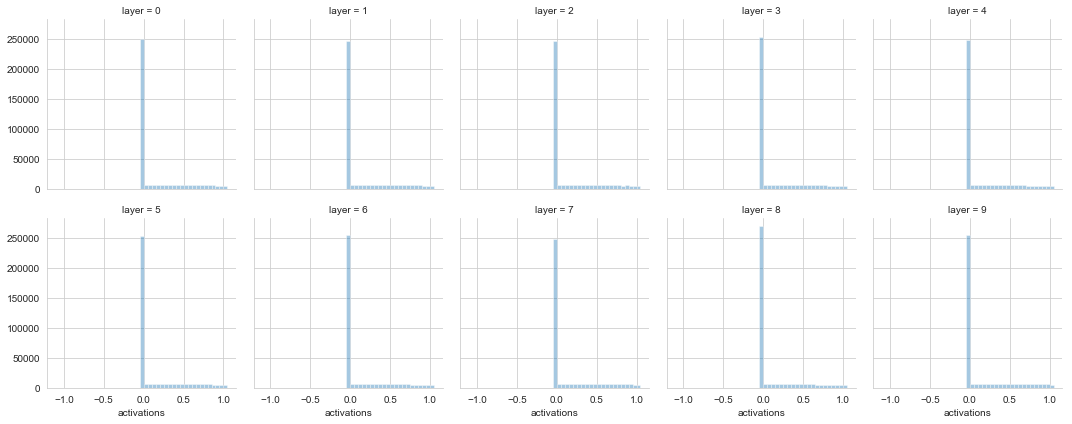

In [19]:
cache = forward_pass('relu', 1/np.sqrt(500/2))
plot_hist(cache)

However, while we can see values different from zero through layers 0-9 above, most activations are still tightly clustered around zero. The **leaky relu function together with He initialization** can help, as it allows for negative activation values without setting them to zero. This way, rather than dying, neurons with negative activation values still have a distinct gradient and can be updated through backpropagation

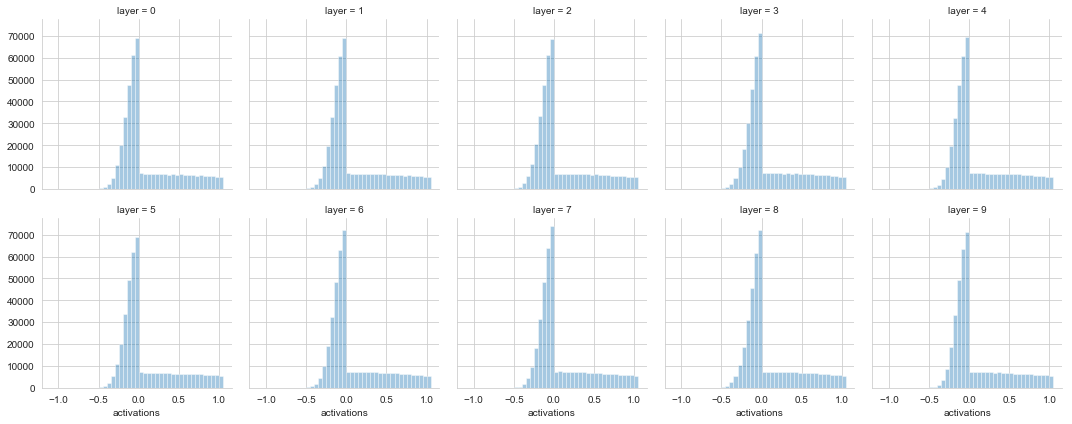

In [7]:
cache = forward_pass('leaky_relu', 1/np.sqrt(500/2))
plot_hist(cache)